In [3]:
from __future__ import division
#import pylion as pl
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from mpl_toolkits.mplot3d import Axes3D
from electrode import (System, PolygonPixelElectrode, PointPixelElectrode, shaped)

import sion as sn

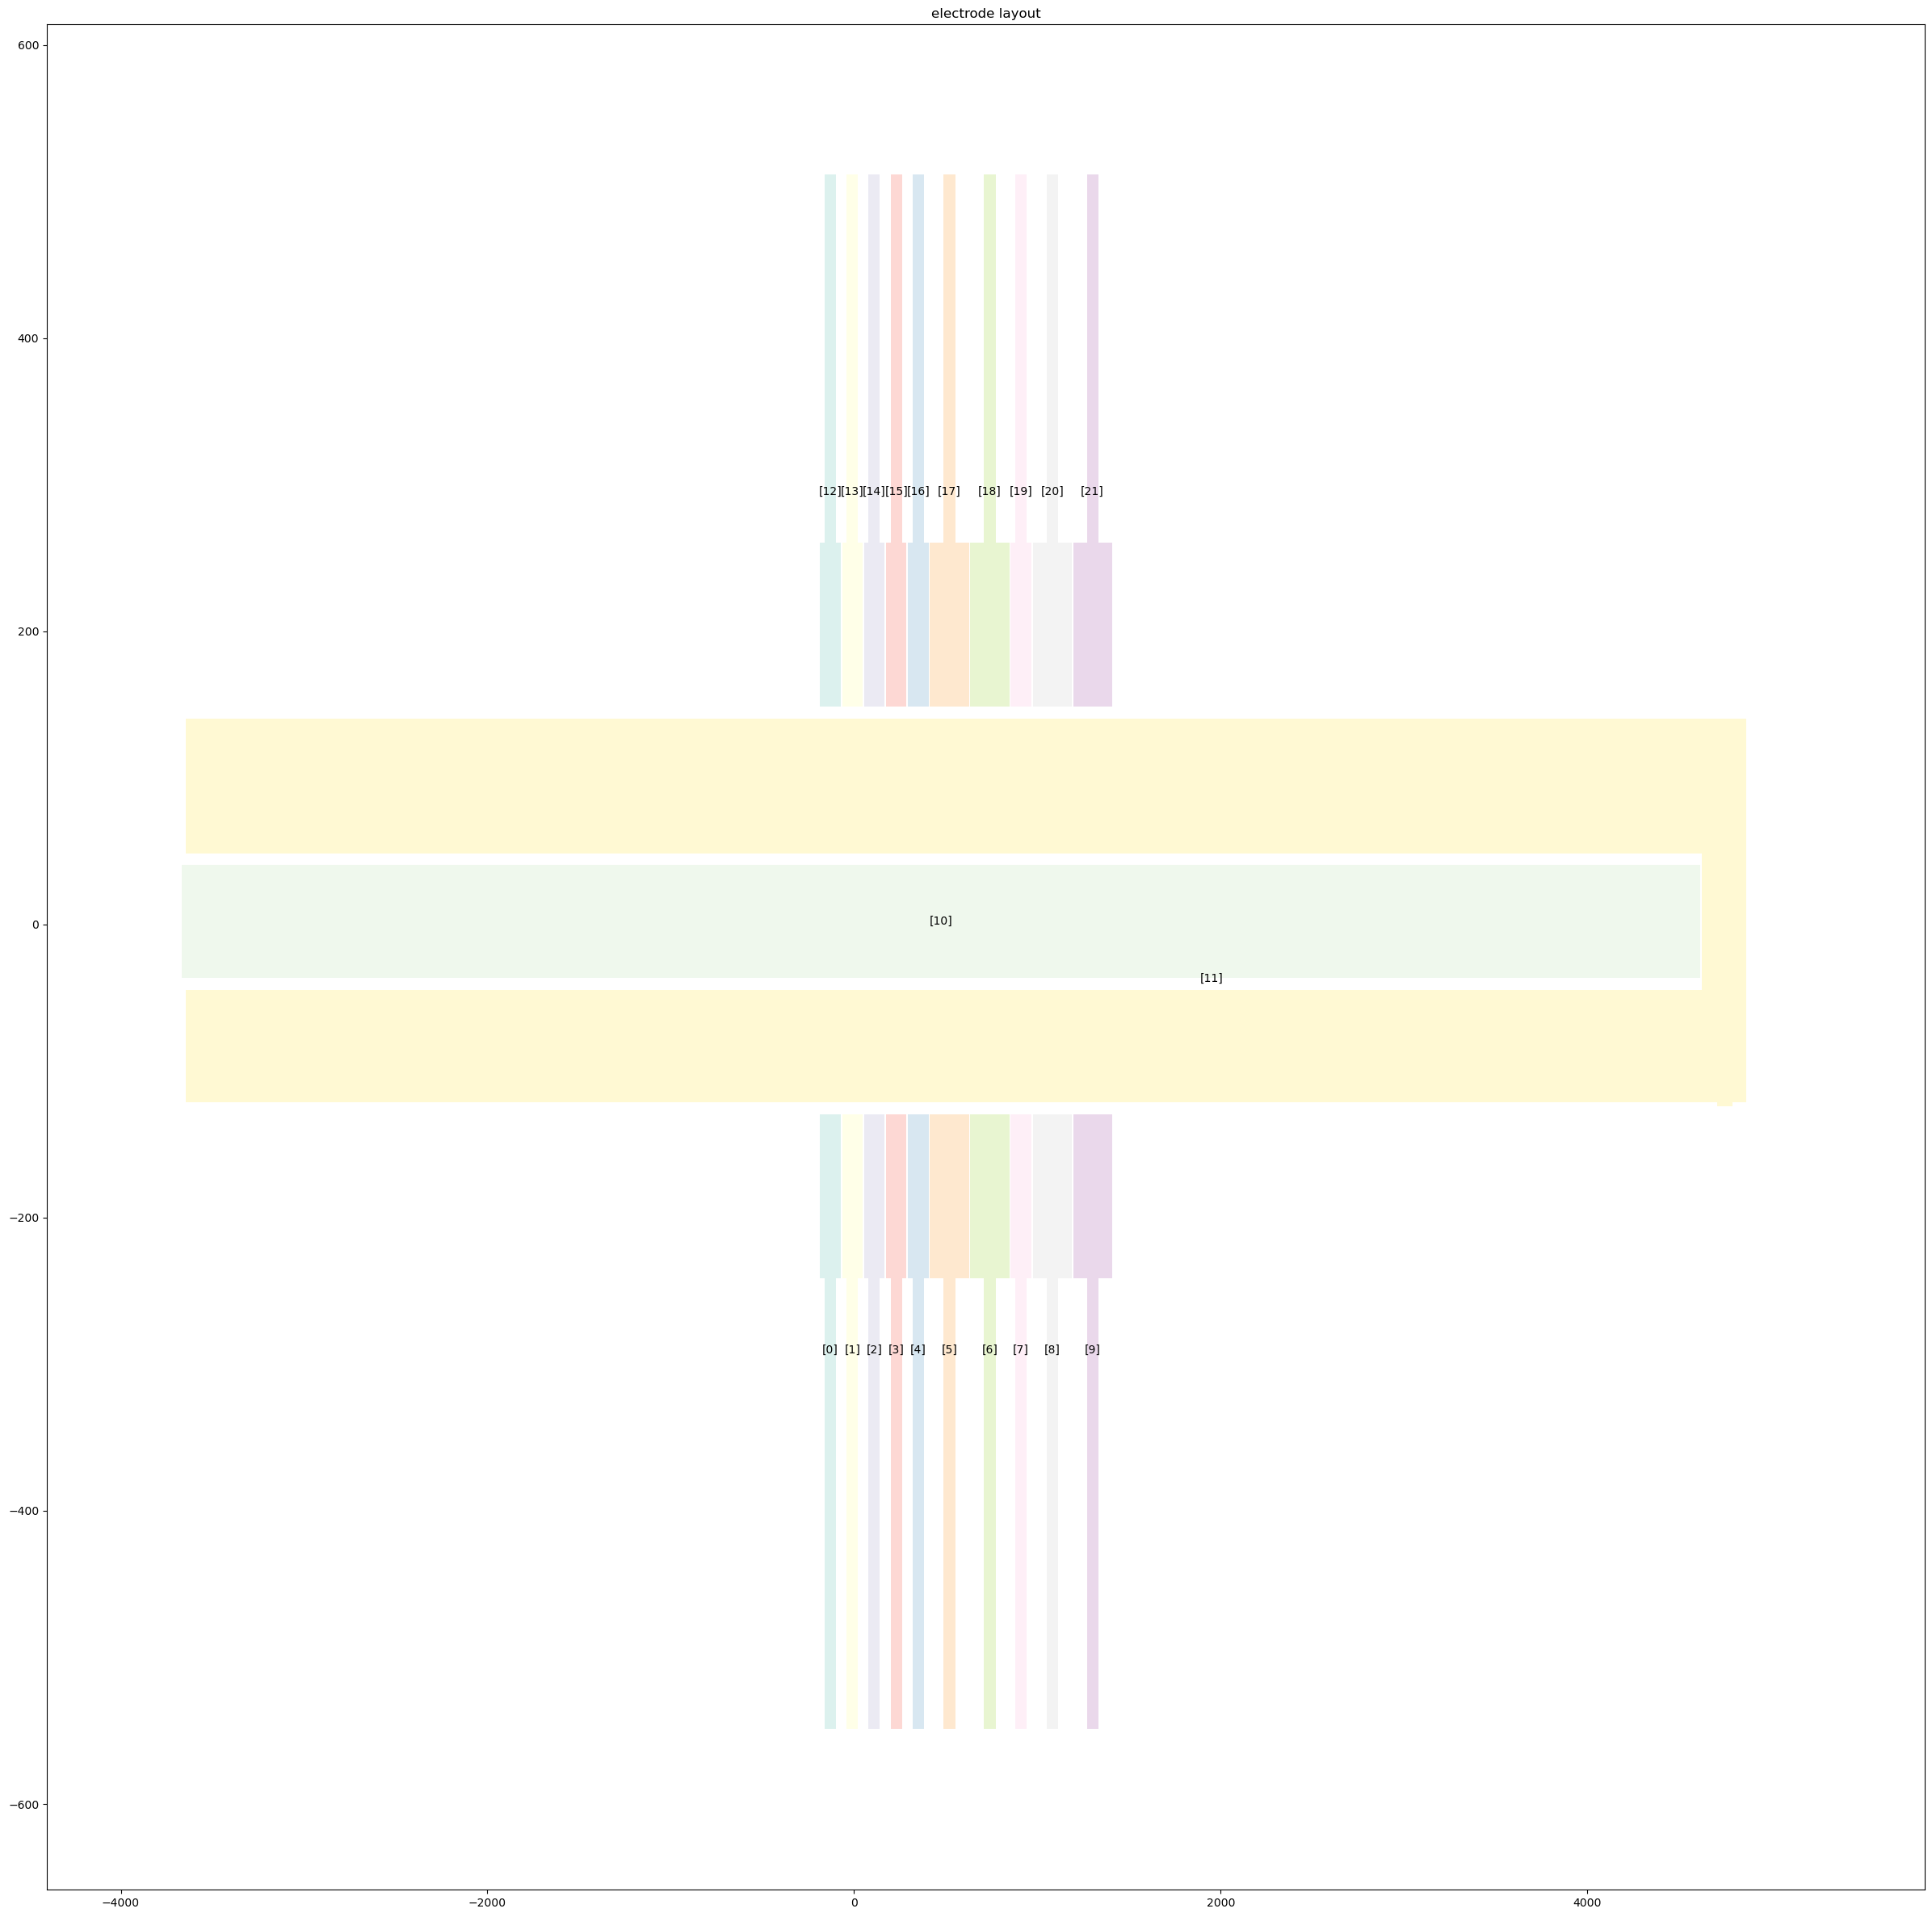

In [17]:
mass = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
L = 1e-6 # µm length scale
s, full_electrode_list = sn.polygons_from_gds('test2.GDS', need_plot = True, need_coordinates = True, L=L)

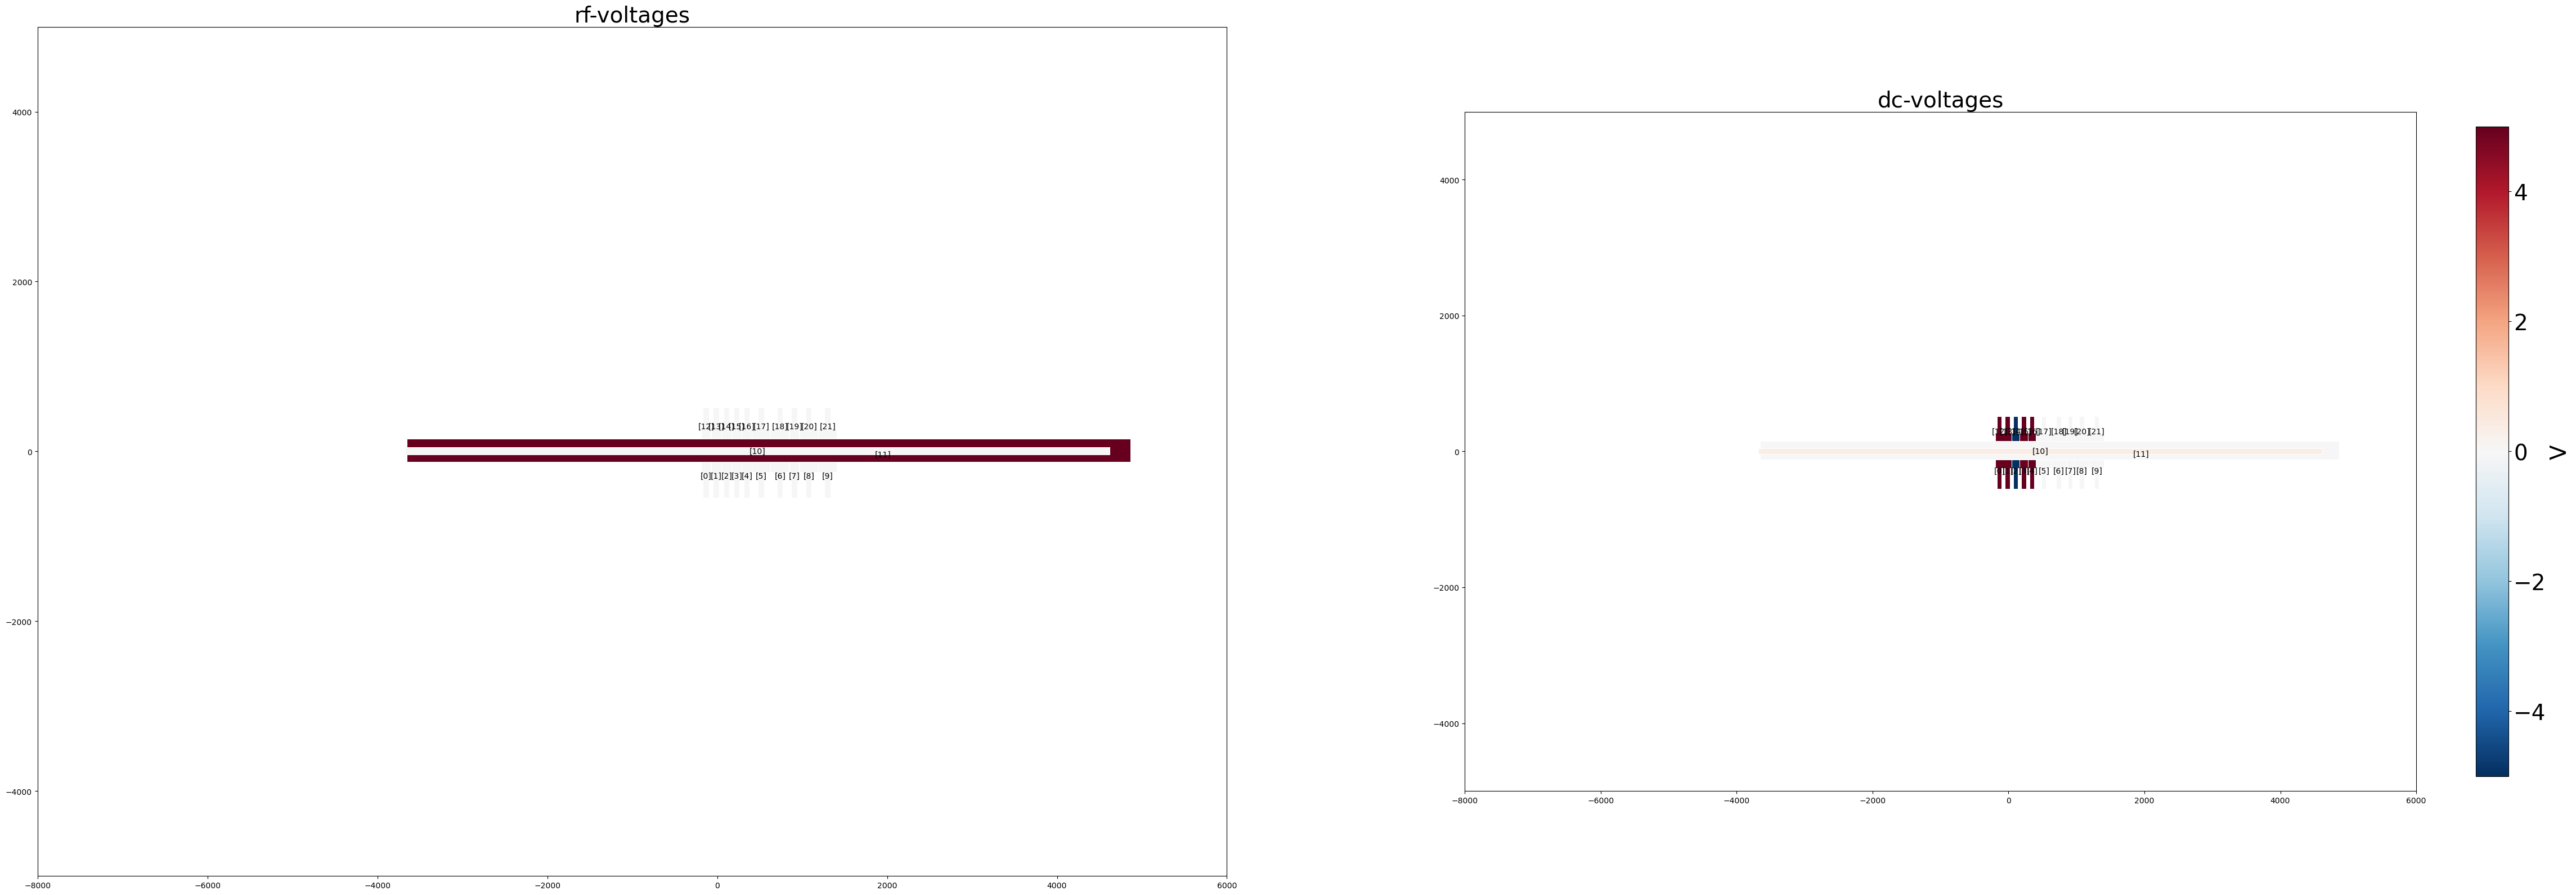

In [19]:
# Global definition of trap parameters. Used for all cells in this notebook
Vrf = 50. # RF peak voltage in V
M = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*30e6 # RF frequency in rad/s
# RF voltage in parametrized form so that the resulting potential equals the RF pseudopotential in eV
Urf = Vrf*np.sqrt(Z/M)/(2*L*Omega)

RF_electrodes = [full_electrode_list[11]]
DC_electrodes = [full_electrode_list[0:10]] + full_electrode_list[12:]

V11=0.354
V0=5
V1=5
V2=-5
V3=5
V4=5
############################
V5=0
V6=0
V7=0
V8=0
V9=0
#############################
V12=5
V13=5
V14=-5
V15=5
V16=5
#################################
V17=0
V18=0
V19=0
V20=0
V21=0
#########################

s.rfs = np.array([0, 0,0,0,0,0,0,0,0,0,0, Urf, 0, 0, 0, 0, 0,0,0,0,0])
s.RFS = np.array([0, 0,0,0,0,0,0,0,0,0,0, Vrf, 0, 0, 0, 0, 0,0,0,0,0])
s.dcs = 1*np.array([V0, V1, V2, V3, V4, V5, V6, V7, V8, V9, V11, 0, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21])
#rf_set = [Vrf]
#dc_set = [V0, V1, V2, V3, V4, V5, V6]
omegas = [Omega]

fig, ax = plt.subplots(1, 2, figsize=(60, 30))
s.plot_voltages(ax[0], u=s.rfs)
s.plot_voltages(ax[1], u=s.dcs)
ax[0].set_title("rf-voltages", fontsize = 28)
# ax[0] addresses the first plot in the subplots - set_title gives this plot a title
ax[1].set_title("dc-voltages", fontsize = 28)
for axi in ax.flat:
    axi.set_aspect("equal")
    axi.set_xlim(-8000, 6000)
    axi.set_ylim(-5000, 5000)
cmap = plt.cm.RdBu_r
norm = mpl.colors.Normalize(vmin=np.min(s.dcs), vmax=np.max(s.dcs))

cb = fig.colorbar(plt.cm.ScalarMappable(norm = norm, cmap=cmap),ax=axi,orientation = 'vertical', shrink =0.5, pad = 0.05)

cb.ax.tick_params(labelsize=28)
cb.set_label('V', fontsize = 28)

In [20]:
with s.with_voltages(dcs = np.zeros(22), rfs = None):
    x0 = s.minimum([0,1.5,75], axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")

x1 = s.minimum(x0, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
print('The minimum is (%.3g, %.3g, %.3g)' % (x1[0], x1[1], x1[2]))
print('The RF minimum is (%.3g, %.3g, %.3g)' % (x0[0], x0[1], x0[2]))
print('Distance from RF-minimum: (%.3g, %.3g, %.3g)' % (x1[0] - x0[0], x1[1] - x0[1], x1[2] - x0[2]))

The minimum is (110, -3.39, 71.5)
The RF minimum is (-2.49e-05, -2.12, 77.7)
Distance from RF-minimum: (110, -1.27, -6.18)


In [21]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint, Bounds

lower_bounds = np.array([-10, -10, -10, -10, -10, -5, -10,-10, -10, -10, -10])
upper_bounds = np.array([10, 10, 10, 10, 10, 5, 10,10, 10, 10, 10])

# Creating the Bounds object
bounds = Bounds(lower_bounds, upper_bounds)

x_target=-2.5
xdes=x_target

#Vint=[5,5,-5,5,5,0.5,5,5,-5,5,5]
Vint=[ 5, -4,  4.77, -0.32, -0.3,
        0.36,  5.1, -4.5,  4.6, -0.34,
       -0.31]
def opt_step(Vint, xdes):

    V0=Vint
    def objective(V,s,Urf):
    
        #s.rfs = np.array([0, Urf, 0, 0, 0, 0, 0, 0])
        #s.dcs = 1*np.array([V[0], 0, V[1], V[2], V[3], V[4], V[5], V[6]])
        s.rfs = np.array([0, 0,0,0,0,0,0,0,0,0,0, Urf, 0, 0, 0, 0, 0,0,0,0,0])
        s.dcs = 1*np.array([V[0], V[1], V[2], V[3], V[4], 0, 0, 0, 0, 0, V[5], 0, V[6], V[7], V[8], V[9], V[10], 0, 0, 0, 0, 0])
        with s.with_voltages(dcs = np.zeros(22), rfs = None):
            x0 = s.minimum([0,-2.1,75], axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")

        x1 = s.minimum(x0, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
        loss=(x1[0] - xdes)**2+ (x1[1] - x0[1])**2+( x1[2] - x0[2])**2
        return loss

    result = minimize(lambda V: objective(V, s, Urf), V0, method='SLSQP',  bounds=bounds)
    Vf=result.x
    return Vf

for i in range(3):
    xdes=x_target-i*0.2
    Vint=opt_step(Vint,xdes)
    


In [22]:
Vf=Vint
s.rfs = np.array([0, 0,0,0,0,0,0,0,0,0,0, Urf, 0, 0, 0, 0, 0,0,0,0,0])
s.dcs = 1*np.array([Vf[0], Vf[1], Vf[2], Vf[3], Vf[4], 0, 0, 0, 0, 0, Vf[5], 0, Vf[6], Vf[7], Vf[8], Vf[9], Vf[10], 0, 0, 0, 0, 0])
with s.with_voltages(dcs = np.zeros(22), rfs = None):
    x0 = s.minimum([0,-2.1,75], axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")

x1 = s.minimum(x0, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")

print('The minimum is (%.3g, %.3g, %.3g)' % (x1[0], x1[1], x1[2]))
#print('The RF minimum is (%.3g, %.3g, %.3g)' % (x0[0], x0[1], x0[2]))
print('Distance from RF-minimum: (%.3g, %.3g, %.3g)' % (x1[0] - xdes, x1[1] - x0[1], x1[2] - x0[2]))

The minimum is (-2.9, -2.12, 77.7)
Distance from RF-minimum: (-0.00033, -9.68e-06, 5.54e-05)


In [23]:
Vf

array([ 5.00451831, -3.98188411,  4.78213336, -0.31644099, -0.29890916,
        0.36523143,  5.09066932, -4.51412752,  4.59320565, -0.34184593,
       -0.31055861])

In [24]:

# Get trap frequencies
try:
    curv_z, mod_dir=s.modes(x1,sorted=False)
    omega_sec=np.sqrt(Z*curv_z/M)/(L*2*np.pi) * 1e-6
    print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))
    print("In directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )
    e1 = np.array([0,0,1])
    alp = np.arccos(np.inner(mod_dir[2],e1))
    print('Angle of secular modes rotation alpha:', alp)
except:
    print("Secular frequencies not found")


Secular frequencies: (0.922, 2.853, 3.34) MHz
In directions
a: [ 0.99995039 -0.00902063 -0.00422435] 
b: [ 0.00850923  0.99406211 -0.10848091] 
c: [0.00517783 0.10843958 0.99408956]
Angle of secular modes rotation alpha: 0.10877752110471905


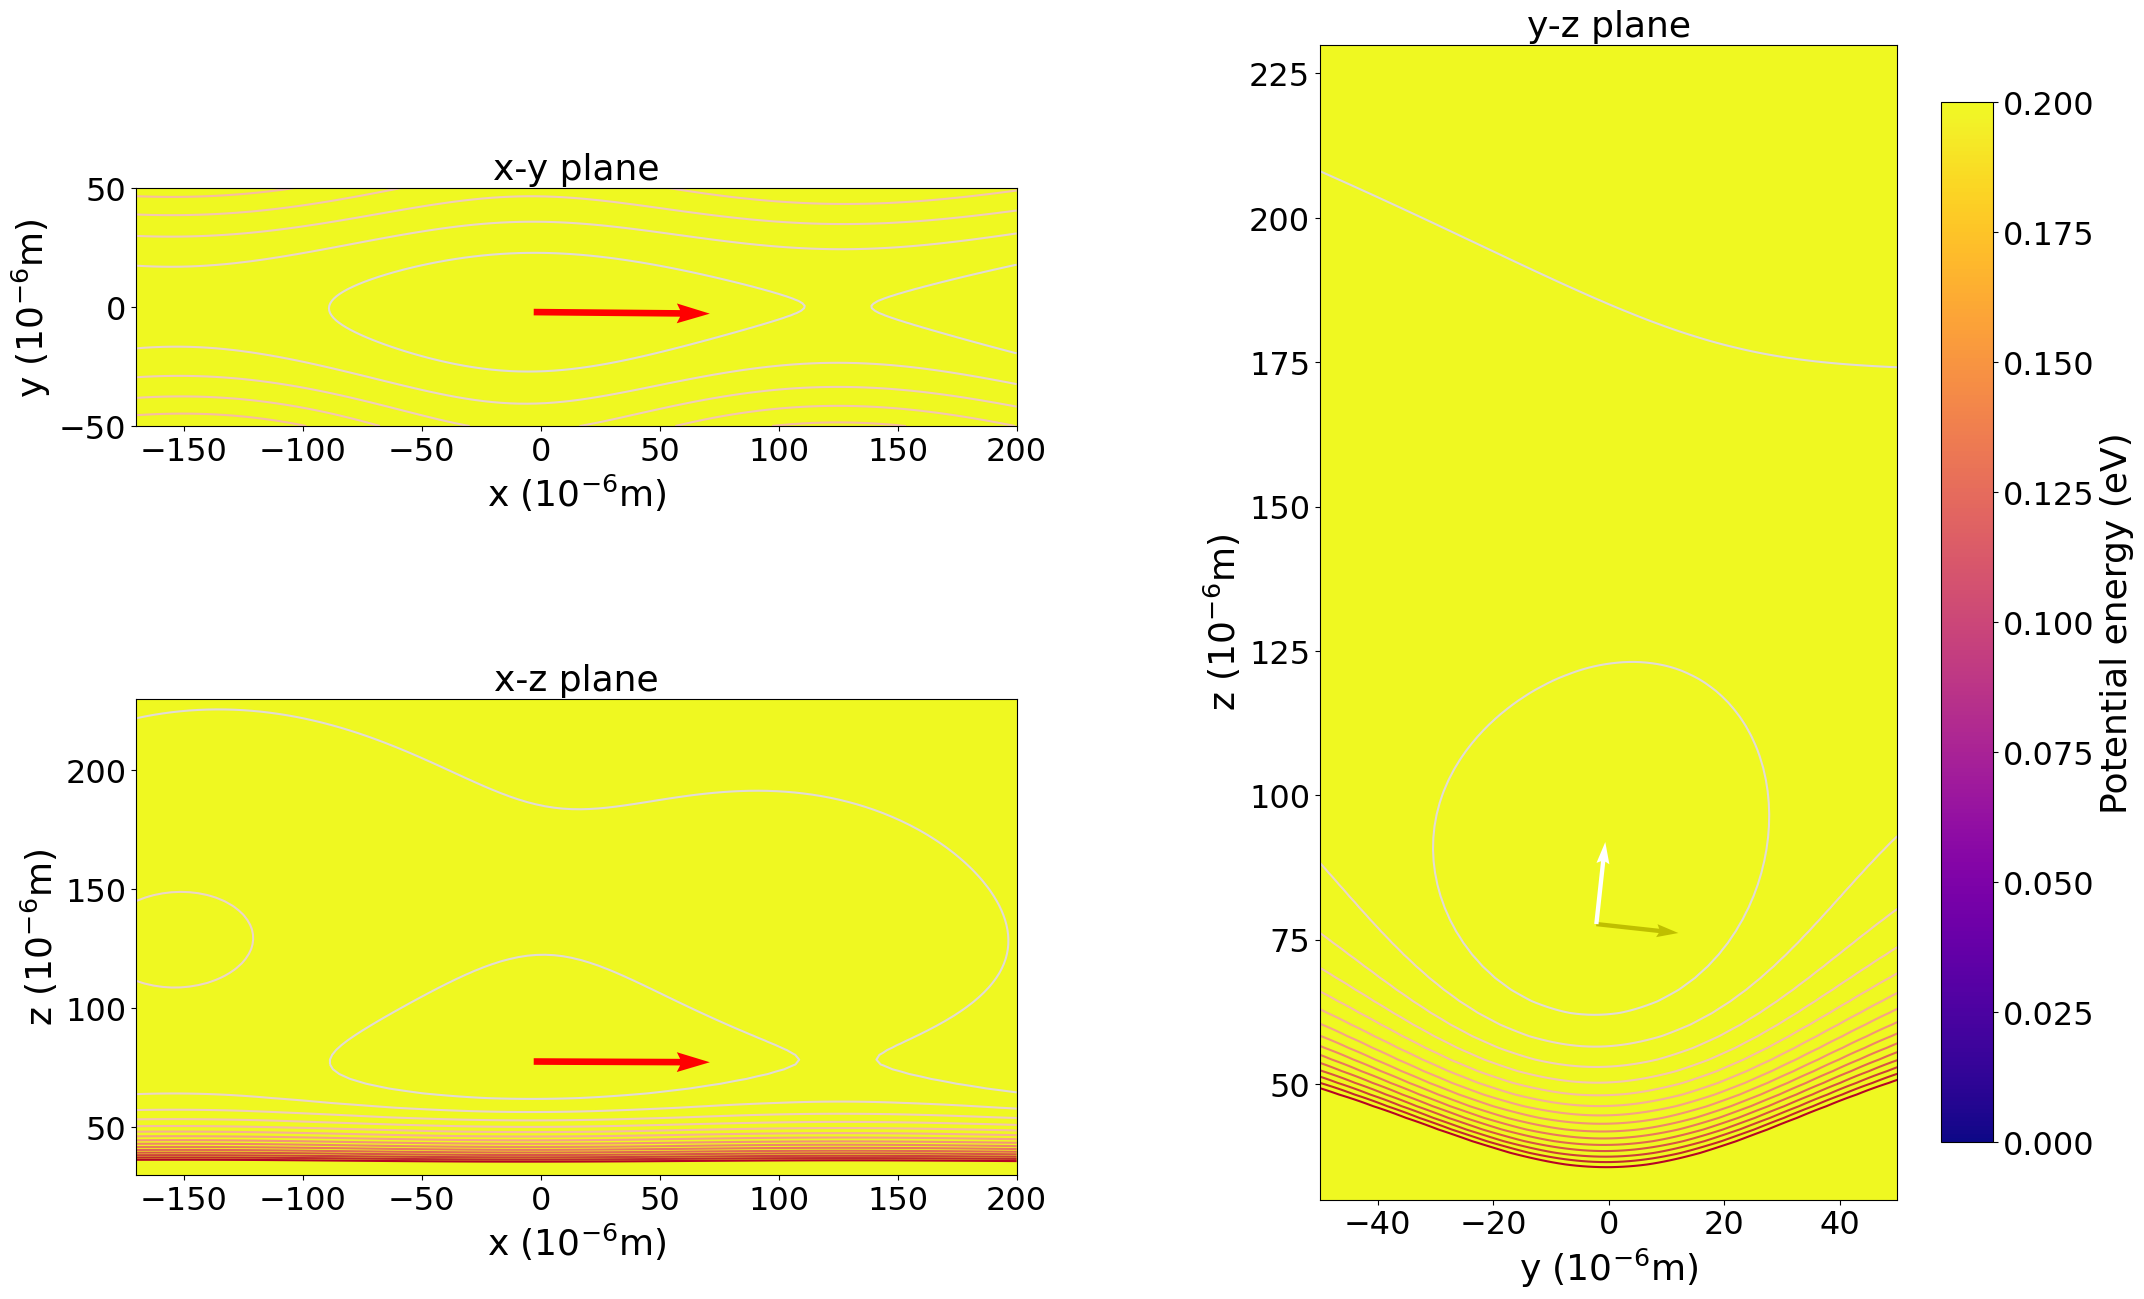

In [25]:
n=100 # resolution of meshgrid = resolution of 2D plots
xmin, xmax = -170, 200 #set the plot ranges
ymin, ymax = -50, 50
zmin, zmax = 30, 230
x_cut, y_cut, z_cut = x1[0], x1[1], x1[2]# position of the yz-, xz-, xy- crossection
v = np.arange(-0.5, 1, 0.05)# set the range for contour lines (range in eV)
v_min, v_max = 0, 0.2 # set the range for colour map (range in eV)
fs = 26 #set the fontsize
ls = 23 #set the labelsize
fig = plt.figure()
fig.set_size_inches(25,15)

# x-y cross section
ax1 = plt.subplot2grid((2,2), (0,0))
ax1.set_title("x-y plane" ,fontsize=fs)
ax1.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
ax1.set_ylabel('y ($10^{-6}$m)',fontsize=fs)
ax1.tick_params(axis='x', labelsize=ls)
ax1.tick_params(axis='y', labelsize=ls)
xyz = np.mgrid[xmin:xmax:1j*n, ymin:ymax:1j*n, z_cut:z_cut+1]
pot = shaped(s.potential)(xyz)
x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
CS=ax1.contour(x, y, p, v, cmap=plt.cm.coolwarm)
im = ax1.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,ymin,ymax))
im.set_interpolation('bilinear')

# x-z cross section
ax2 = plt.subplot2grid((2,2), (1,0))
ax2.set_title("x-z plane" ,fontsize=fs)
ax2.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
ax2.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
ax2.tick_params(axis='x', labelsize=ls)
ax2.tick_params(axis='y', labelsize=ls)
xyz = np.mgrid[xmin:xmax:1j*n, y_cut:y_cut+1, zmin:zmax:1j*n]
pot = shaped(s.potential)(xyz)
x, z, p = (_.reshape(n, n) for _ in (xyz[0], xyz[2], pot))
CS=ax2.contour(x, z, p, v, cmap=plt.cm.coolwarm)
im = ax2.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,zmin,zmax))
im.set_interpolation('bilinear')

# y-z cross section
ax3 = plt.subplot2grid((2,2), (0,1), rowspan=2)
ax3.set_title("y-z plane" ,fontsize=fs)
ax3.set_xlabel('y ($10^{-6}$m)',fontsize=fs)
ax3.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
ax3.tick_params(axis='x', labelsize=ls)
ax3.tick_params(axis='y', labelsize=ls)
xyz = np.mgrid[x_cut:x_cut+1, ymin:ymax:1j*n, zmin:zmax:1j*n]
pot = shaped(s.potential)(xyz)
x, z, p = (_.reshape(n, n) for _ in (xyz[1], xyz[2], pot))
CS=ax3.contour(x, z, p, v, cmap=plt.cm.coolwarm)
im = ax3.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(ymin,ymax,zmin,zmax))
im.set_interpolation('bilinear') 

# add colorbar
cb = fig.colorbar(im, ax=ax3, shrink=0.9)
cb.ax.tick_params(labelsize=ls)
cb.set_label('Potential energy (eV)', fontsize = fs)

#add secular frequencies
#change color and scale (the fewer, the longer the arrow)
ax1.quiver(*[[x1[0]],[x1[1]]], mod_dir[0][0], mod_dir[0][1], color=['r'], scale = 5)
ax2.quiver(*[[x1[0]],[x1[2]]], mod_dir[0][0], mod_dir[0][2], color=['r'], scale = 5)
ax3.quiver(*[[x1[1]],[x1[2]]], mod_dir[1][1], mod_dir[1][2], color=['y'], scale = 7)
ax3.quiver(*[[x1[1]],[x1[2]]], mod_dir[2][1], mod_dir[2][2], color=['w'], scale = 7)

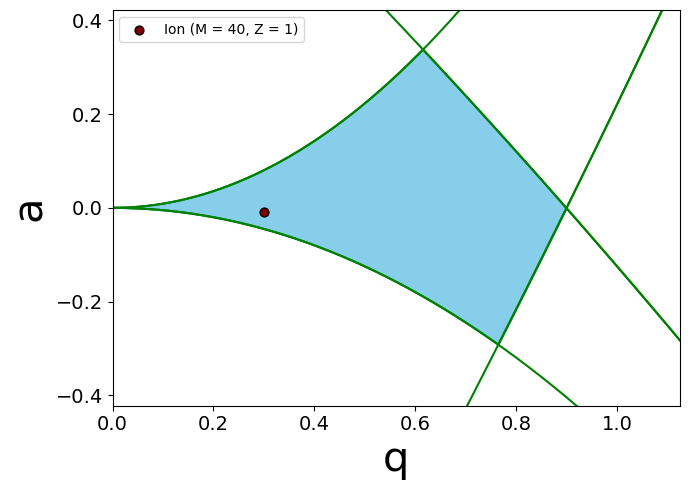

{'Ion (M = 40, Z = 1)': {'a': -0.008592949467291462, 'q': 0.299229792581823},
 'α': 0.5599515019457175,
 'θ': 3.11070944747398,
 'Range of achievable a': [-0.292012092936992, 0.3378617976361596],
 'Critical q': 0.8992922871406938}


In [26]:
with s.with_voltages(dcs = s.dcs, rfs = s.RFS):
    params = sn.stability(s, mass, Omega, minimum = x1) 

import pprint
pprint.pprint(params, sort_dicts=False)